This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# # define the colors
# cmap = mpl.colors.ListedColormap(['white', 'k'])

# # create a normalize object the describes the limits of
# # each color
# bounds = [-.5, 0.5, 1.5]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


In [3]:
jax.devices()

[CpuDevice(id=0)]

# Read the data

In [4]:
# File and folder paths
f_para = Path("./data/Output_512.csv")
f_state = Path("./data/Input_512.csv")


In [5]:
df_para, df_state = pd.read_csv(f_para),pd.read_csv(f_state)

In [7]:
y_vars, x_vars = df_para.keys().to_list(), df_state.keys().to_list()
y, x = df_para.values, df_state.values

In [8]:
x.shape, y.shape

((513, 1458), (513, 2))

# Load the preliminary analysis results

In [9]:
f_data_save = Path("./results/data-corr")
data = Data(x, y)
data.load(f_data_save)


# Plot the sensitivity analysis results

In [10]:
def plot_sensitivity(sensitivity_mask, ax=None, xlabels=None, ylabels=None):

    if xlabels is not None and ylabels is not None:
       sensitivity_mask = pd.DataFrame(sensitivity_mask, index=xlabels, columns=ylabels)

    ax = sns.heatmap( sensitivity_mask, ax=ax, cmap='Blues')
    ax.set(title='Sensitivity heatmap')

def plot_sensitivity_mask(sensitivity_mask, ax=None, xlabels=None, ylabels=None):
    # define the colors
    cmap = mpl.colors.ListedColormap(['lightgrey', 'tab:blue'])

    # create a normalize object the describes the limits of
    # each color
    bounds = [-.5, 0.5, 1.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    if xlabels is not None and ylabels is not None:
       sensitivity_mask = pd.DataFrame(sensitivity_mask, index=xlabels, columns=ylabels)

    ax = sns.heatmap(
        sensitivity_mask, ax=ax, cmap=cmap, norm=norm, 
        cbar_kws={"ticks": [0, 1]}
      )
    ax.collections[0].colorbar.set_ticklabels(["sensitive", "not sensitive"], rotation=90)
    ax.set(title='Sensitivity mask')


[Text(0.5, 1.0, 'Sensitivity')]

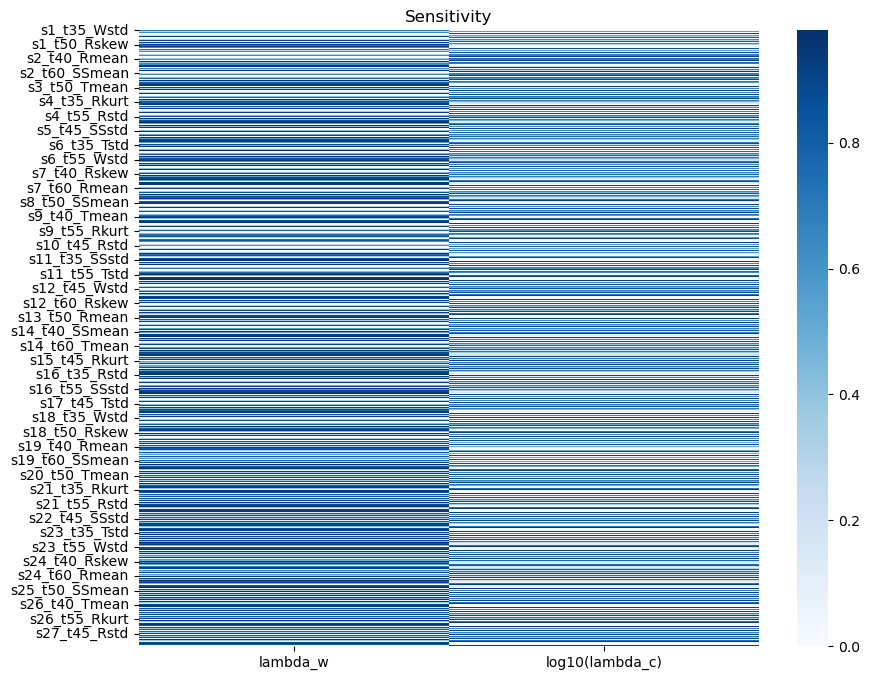

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity(data.sensitivity, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Sensitivity')


[Text(0.5, 1.0, 'Sensitivity mask')]

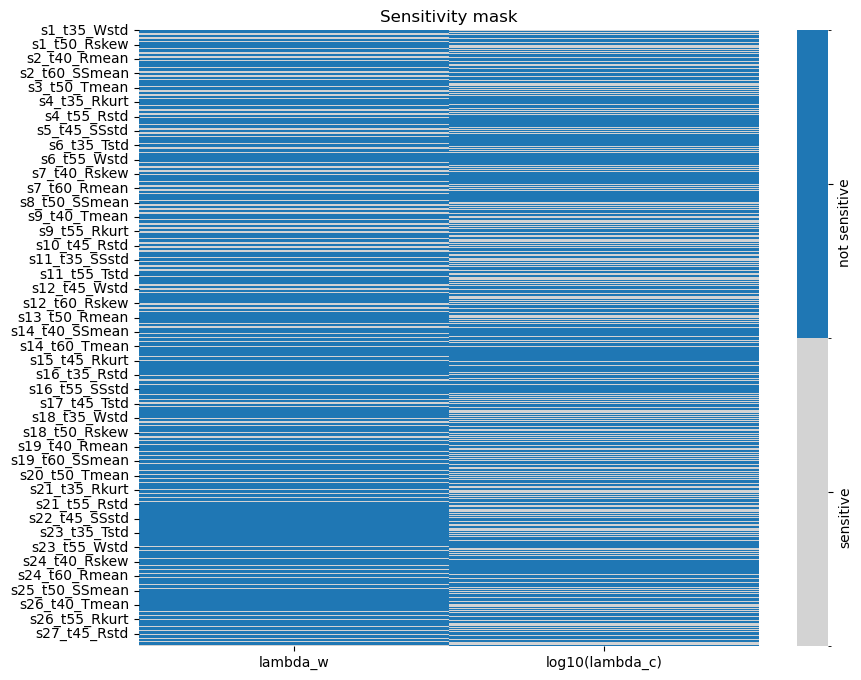

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity_mask(data.sensitivity_mask, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Sensitivity mask')


[Text(0.5, 1.0, 'Conditional sensitivity mask')]

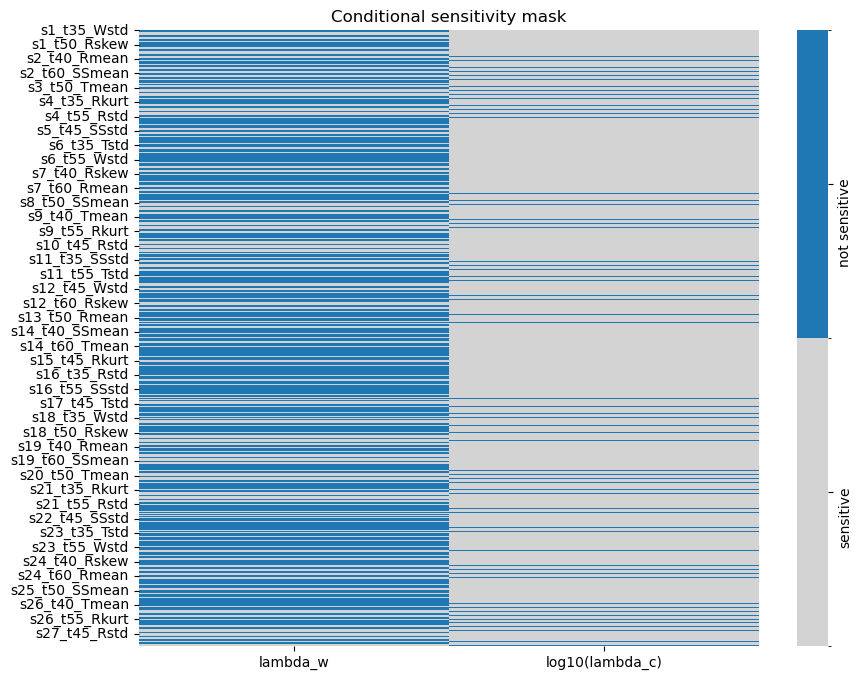

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity_mask(data.cond_sensitivity_mask, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Conditional sensitivity mask')


## Plots specific to cloud chamber system

In [14]:
# Let's make a big pandas dataframe
loc = [int(xv.split('_')[0][1:]) for xv in x_vars]
time = [int(xv.split('_')[1][1:]) for xv in x_vars]
varn = [xv.split('_')[2] for xv in x_vars]
df_sen = pd.DataFrame()
df_sen['loc']  = loc
df_sen['time'] = time
df_sen['varn'] = varn
for i,yvarn in enumerate(y_vars):
    df_sen[yvarn] = data.sensitivity[:,i]
    df_sen[yvarn+"_mask"] = data.sensitivity_mask[:,i]
    df_sen[yvarn+"_condmask"] = data.cond_sensitivity_mask[:,i]    

varn_set = set(varn)
time_set = set(time)
loc_set = set(loc)

# Set up the gradual changing color lines
cmap = plt.cm.gist_rainbow  # You can choose other colormaps like 'plasma', 'inferno', 'magma', etc.
colors = cmap(np.linspace(0, 1, len(loc_set)))


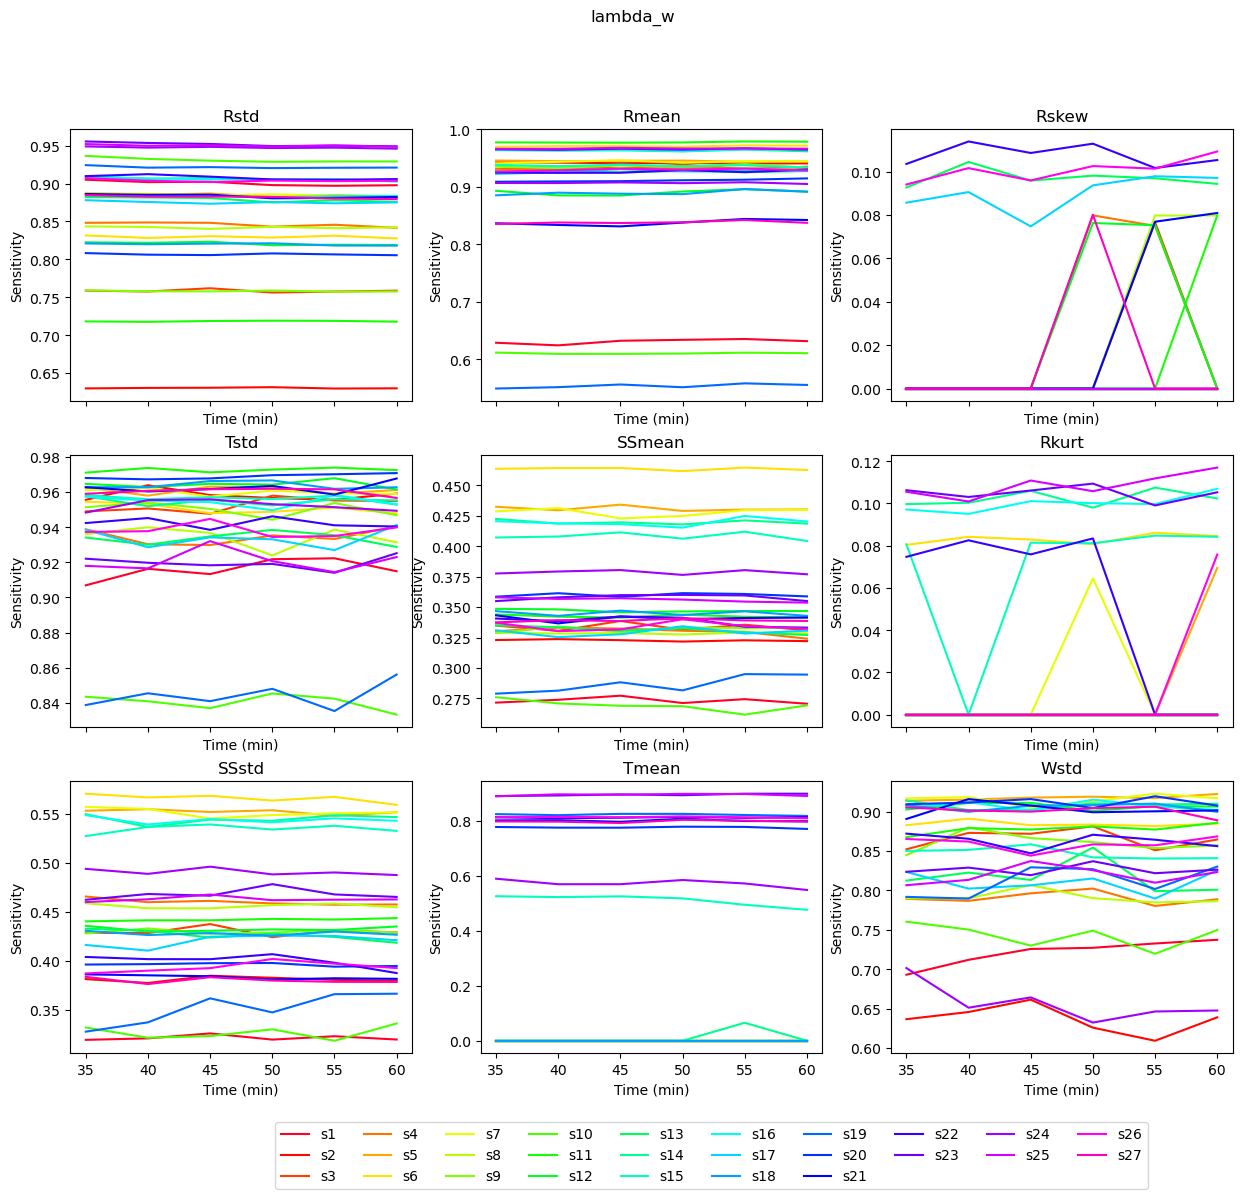

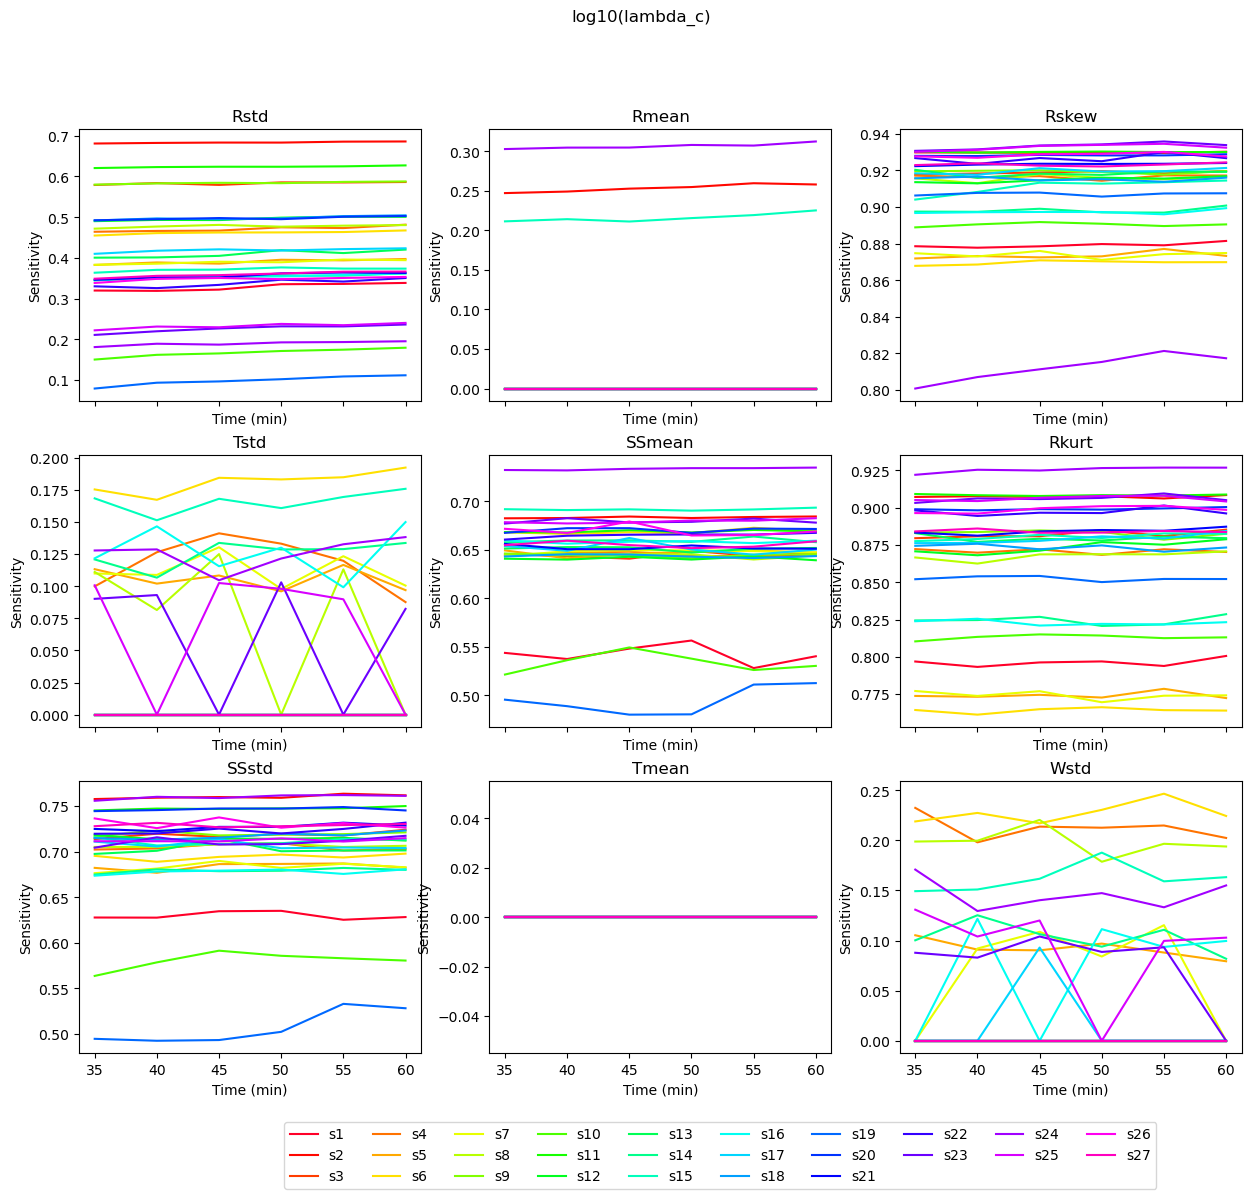

In [15]:
# Plot -- sensitivity only
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)]
            t, d = df['time'].values, df[yvarn].values
            ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)


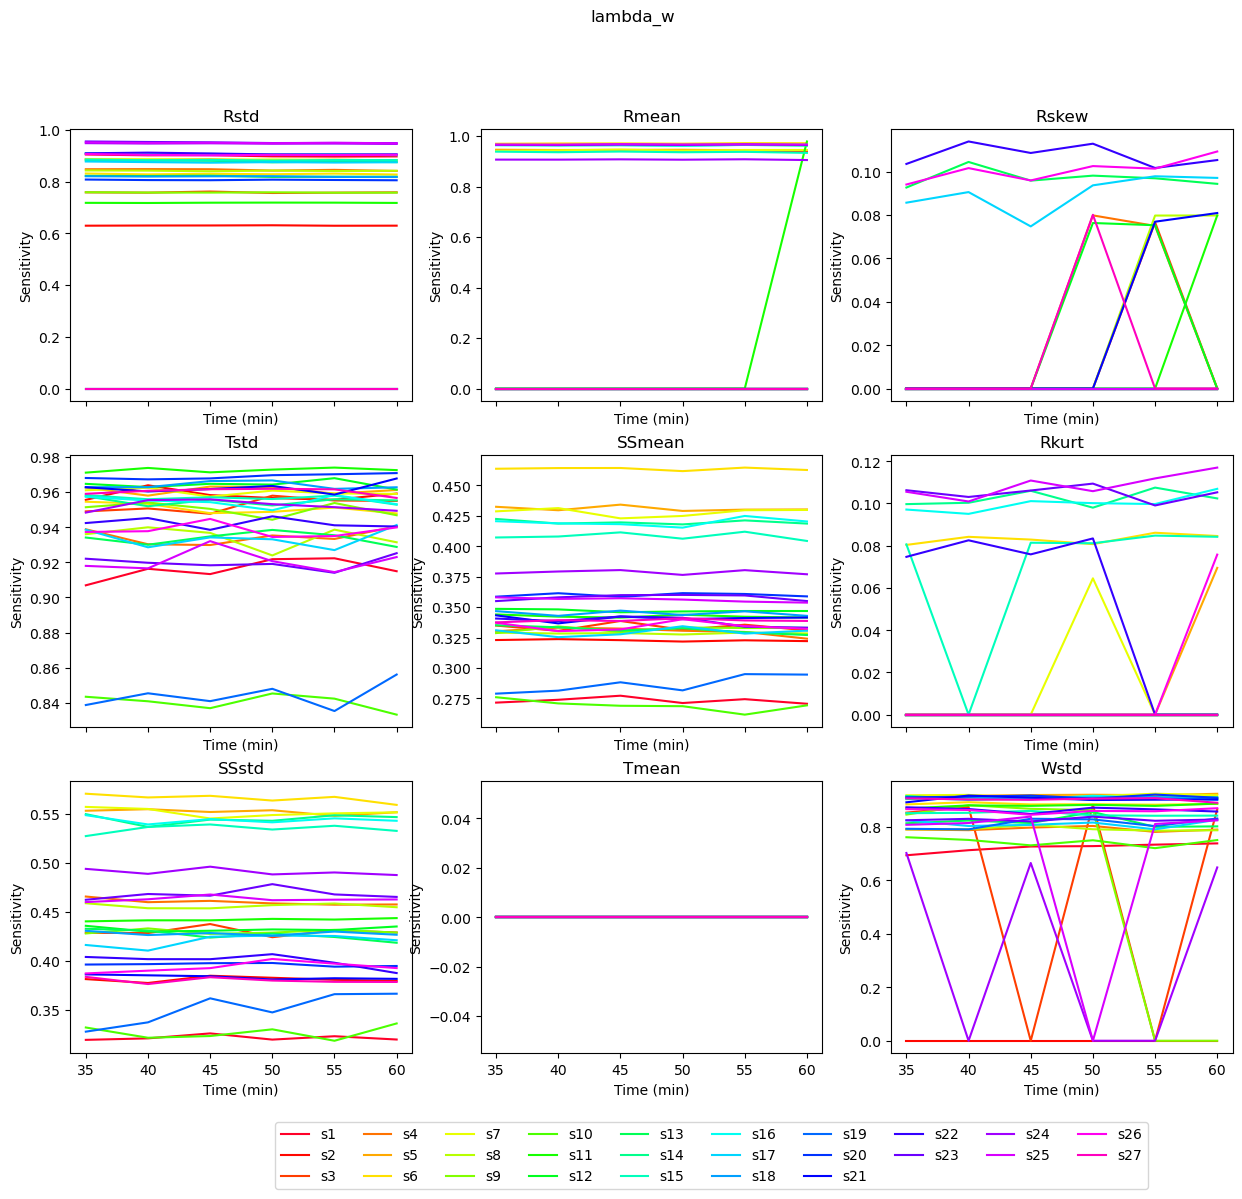

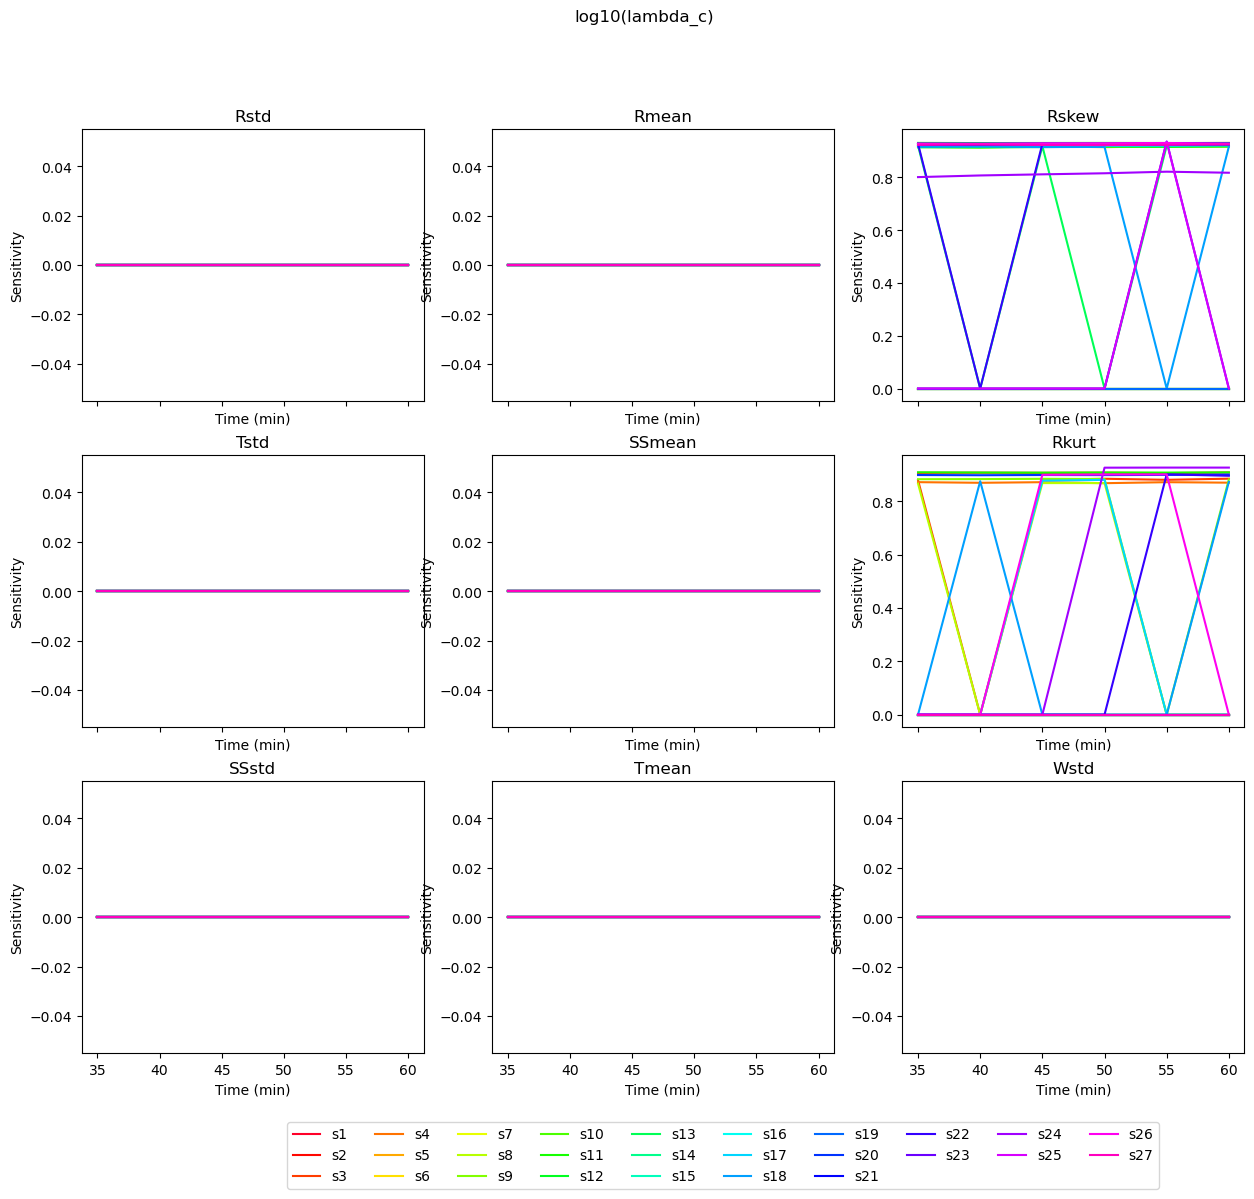

In [16]:
# Plot -- sensitivity filtered by conditional mask
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)].copy()
            t, d = df['time'].values, df[yvarn].values
            m = df[yvarn+'_condmask']
            d[~m] = 0 
            ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)
